In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
import cv2
from sklearn.utils import shuffle

Using TensorFlow backend.


In [0]:
import random
random.seed(2) # Python
np.random.seed(1) #numpy
from tensorflow import set_random_seed
set_random_seed(3) # Tensorflow

In [0]:
#The path to the omniglot data
root_path = "./drive/My Drive/"
train_path = os.path.join(root_path,'Dataset/training') 
validation_path = os.path.join(root_path,'Dataset/validation')
model_save_path=os.path.join(root_path,'transfer_learning_siamese_model1.h5')
INIT_WEIGHTS = os.path.join(root_path, 'init_weights.hdf5')
CHECKPOINTED_WEIGHTS = os.path.join(root_path, 'checkpointed_weights.hdf5')

In [0]:



def load_image(path, n = 0):
    X = []
    
    #Load every srud seperately and place that in one tensor
    for student in os.listdir(path):
#         print("Loading student: " + student)
        student_path = os.path.join(path, student)
       
        category_images = []
            
        if not os.path.isdir(student_path):
                continue
            
            #Read evey image with in the directory
        for filename in os.listdir(student_path):
                image_path = os.path.join(student_path, filename)
                image = imageio.imread(image_path)
                width = 105
                height = 105 # keep original height
                dim = (height,width)
 
                # resize image
                image = cv2.resize(image, dim)
                image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                image= np.expand_dims(image, axis=0)
#                 print(image_path)
                #Image preprocessing
                image = image/255
                image = 1 - image
                
                X.append(image)
                
        
    X = np.stack(X)
    return X

In [0]:
print("Loading Training Set")
Xtrain = load_image(train_path)
print(Xtrain.shape)

Loading Training Set
(1470, 1, 105, 105)


In [0]:
print("Now loading evaluation set")
Xval = load_image(validation_path)
print(Xval.shape)

Now loading evaluation set
(646, 1, 105, 105)


In [0]:
def get_batch(data, batch_size):
    n_classes, n_examples, h, w = data.shape
    
    pairs = [np.zeros((batch_size, 1, h, w)) for i in range(2)]
    
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    categories = np.random.choice(n_classes, size = (batch_size), replace = False)
    
    for i in range(batch_size):
        category = categories[i]
        
        idx1 = np.random.randint(0, n_examples)
        pairs[0][i,:,:,:] = data[category, idx1].reshape(1, h,w)
        idx2 = np.random.randint(0, n_examples)
        
        if targets[i] == 0:
            category_2 = category
        else:
            category_2 = (category + np.random.randint(1, n_classes)) % n_classes
 
        
        pairs[1][i,:,:,:] = data[category_2, idx2].reshape(1, h, w)
        
    return pairs, targets
        



In [0]:
def generate(data,batch_size):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(Xtrain,batch_size)
            yield (pairs, targets)    


 

In [0]:
def make_oneshot_task(N,data,language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        n_classes, n_examples, w, h = data.shape
        indices = np.random.randint(0,n_examples,size=(N,))
        categories = np.random.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1 = np.random.randint(0, n_examples)
        ex2 = np.random.randint(0, n_examples)
        # ex1, ex2 = np.random.choice(n_examples,replace=False,size=(0,))
        test_image = np.asarray([data[true_category,ex1,:,:]]*N).reshape(N, 1, w,h)
        support_set = data[categories,indices,:,:]
        support_set[0,:,:] = data[true_category,ex2]
        support_set = support_set.reshape(N, 1, w,h)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    

                   

In [0]:
def test_oneshot(model,N,k,data,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = make_oneshot_task(N,data)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    


In [0]:
def train(model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),)

In [0]:
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import time
import pickle

In [0]:
#Contrastive Loss
def euclid_dist(input_pair):
    x, y = input_pair
    distance = K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))
    return distance

def euclid_dist_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = -1 * y_true + 1
    return K.mean((1-y_true) * K.square(y_pred) + y_true *  K.square(K.maximum(margin - y_pred, 0.0)))

def acc(y_true, y_pred):
    ones = K.ones_like(y_pred)
    return K.mean(K.equal(y_true, ones - K.clip(K.round(y_pred), 0, 1)), axis=-1)



In [0]:
im_width  =105
im_height =105
im_chan   =1      

In [0]:
input_img =Input(( im_chan,im_height,im_width ), name='img')

# print(input_img)
# Down Block 1
c1 = Conv2D(32,(1,1), activation='relu', kernel_regularizer=l2(2e-4) )(input_img)
p1 = MaxPooling2D(data_format="channels_first") (c1)

#Down Block 2
c2 = Conv2D(128, (1, 1), activation='relu', kernel_regularizer=l2(2e-4)) (p1)
p2 = MaxPooling2D(data_format="channels_first") (c2)

#Down Block 3
c3 = Conv2D(128, (1, 1), activation='relu', kernel_regularizer=l2(2e-4)) (p2)
p3 = MaxPooling2D(data_format="channels_first") (c3)

#Down Block 4
c4 = Conv2D(256, (1, 1), activation='relu', kernel_regularizer=l2(2e-4)) (p3)
p4 = MaxPooling2D(data_format="channels_first") (c4)
# # print(p4)
flat = Flatten()(p4)
output = Dense(1, activation='sigmoid')(flat)

# Instantiate the Model
model = Model(input_img, output)

input1 = Input(shape = (1,105,105))
input2 = Input(shape = (1,105,105))

output1 = model(input1)
output2 = model(input2)


distance = Lambda(euclid_dist, output_shape=euclid_dist_shape)([output1, output2])

prediction = Dense(1, activation='sigmoid')(distance)
    
siamese = Model(inputs=[input1, input2], outputs=prediction)
    
optimizer = Adam(lr = 0.00006)
    
siamese.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[acc])

siamese.summary()
os.system("rm {}".format(INIT_WEIGHTS))
siamese.save_weights(INIT_WEIGHTS)












Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            31297       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]   

In [0]:
#Training loop
print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=1 # interval for printing loss (iterations)
batch_size = 32
n_iter = 500
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 30 #how mahy one-shot tasks to validate on?
best = -1
data_path = "./drive/My Drive/"
weights_path= CHECKPOINTED_WEIGHTS
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=get_batch(Xtrain,batch_size)
    loss=siamese.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = test_oneshot(siamese,N_way,n_val,Xval,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path))
            siamese.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {},".format(i,loss))


!
Starting training process!
-------------------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[0.2997086, 0.5]
Time for 1 iterations: 1.3562724590301514
Evaluating model on 30 random 20 way one-shot learning tasks ...
Got an average of 76.66666666666667% 20 way one-shot learning accuracy
Current best: 76.66666666666667, previous best: -1
Saving weights to: ./drive/My Drive/checkpointed_weights.hdf5 

iteration 1, training loss: [0.2997086, 0.5],
[0.29874498, 0.5]
Time for 2 iterations: 2.487671375274658
Evaluating model on 30 random 20 way one-shot learning tasks ...
Got an average of 83.33333333333333% 20 way one-shot learning accuracy
Current best: 83.33333333333333, previous best: 76.66666666666667
Saving weights to: ./drive/My Drive/checkpointed_weights.hdf5 

iteration 2, training loss: [0.29874498, 0.5],
[0.2988238, 0.5]
Time for 3 iterations: 3.1746509075164795
Evaluating model on 30 random 20 way one-shot lear

In [0]:

siamese.load_weights(CHECKPOINTED_WEIGHTS)
for layer in siamese.layers:
    layer.trainable = False
siamese.summary()
siamese.save(os.path.join(root_path, model_save_path))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            31297       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]              

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
import keras.losses
# keras.losses.custom_loss = 
from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model
siamese_net = load_model(model_save_path, custom_objects={'contrastive_loss': contrastive_loss})
siamese_net.compile(loss=contrastive_loss, optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,Xval)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 20, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(test_oneshot(siamese_net, N,trials, Xval, verbose=True))
    train_accs.append(test_oneshot(siamese_net, N,trials, Xtrain, verbose=True))
    nn_acc=test_nn_accuracy(N,trials)
    nn_accs.append(nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")
    
# #plot the accuracy vs num categories for each
# plt.plot(ways, val_accs, "m")
# plt.plot(ways, train_accs, "y")
# plt.plot(ways, nn_accs, "c")

# plt.plot(ways,100.0/ways,"r")
-# plt.show()


Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
---------------------------------------------------------------------------------------------------------------
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 99.33333333333333% 3 way one-shot learning accuracy
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 99.55555555555556% 3 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


---------------------------------------------------------------------------------------------------------------
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 99.33333333333333% 5 way one-shot learning accuracy
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 98.44444444444444% 5 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 5 way one-shot learning tasks ...
---------------------------------------------------------------------------------------------------------------
Evaluating model on 450 random 7 way one-shot learning tasks ...
Got an average of 98.22222222222223% 7 way one-shot learning accuracy
Evaluating model on 450 random 7 way one-shot learning tasks ...
Got an average of 97.77777777777777% 7 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 7 way one-shot learning tasks ...
----------------------------------------------------------------------------------

In [0]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, _, h , w = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [0]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

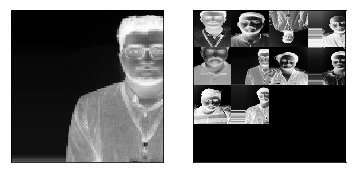

In [0]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(10,Xtrain)
plot_oneshot_task(pairs)

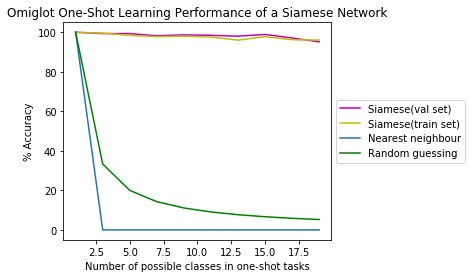

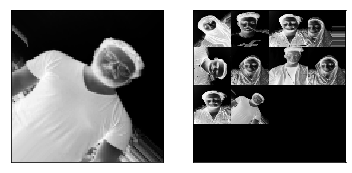

In [0]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(10, Xval)
plt.show()

plot_oneshot_task(inputs)

In [0]:
print(inputs[1].shape)
# plot_oneshot_task(inputs)
p=siamese.predict(inputs)
print(p)

(10, 1, 105, 105)
[[0.33713996]
 [0.22666276]
 [0.44022197]
 [0.4498762 ]
 [0.2806097 ]
 [0.45068043]
 [0.42217284]
 [0.45139903]
 [0.44093594]
 [0.5108104 ]]
